# Anomaly Detection Model 

***Unsupervised anomaly detection on timeseries data generated under a Test Environment***

---

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Training](#Training)
1. [Inference](#Inference)
1. [Epilogue](#Epilogue)

# Introduction
***

In this notebook, we will use the [Amazon SageMaker Random Cut Forest (RCF)](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html) algorithm to train an RCF model on evaporator temperature readings pulled from an IOT device in a test environment. Each record is the temperature reading from a sensor installed on the evaporator. Within our test environment, we invoke an anomaly for 5 minutes at around noon to produce anomolous data points. We will then use our model to see if it's able to pick up on this anomalous event as observed from its predicted "anomaly score" output.

# Setup
***

In [113]:
import boto3
import botocore
import sagemaker
import sys

#specify the locations where the original data is stored
bucket = 'serverlessapphvac323'
prefix = 'rawdata'
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = f"serverlessapphvac323"
downloaded_data_prefix = "rawdata"


def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(
        f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}"
    )

Training input/output will be stored in: s3://serverlessapphvac323/rawdata
Downloaded training data will be read from s3://serverlessapphvac323/rawdata


In [114]:
%%time
#read dataset

import pandas as pd

data_filename = "data.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
parse_dates = ['timestamp']
hvac_data = pd.read_csv(data_filename, delimiter=",", index_col=[0], parse_dates=parse_dates)
hvac_data.head()


CPU times: user 149 ms, sys: 2.16 ms, total: 151 ms
Wall time: 217 ms


,timestamp,EvaporatorTemperature,SensorTemperature,SetPointTemperature
0,2021-06-10 00:00:00,27.0,24.8,27.3
1,2021-06-10 00:01:00,27.0,24.9,27.3
2,2021-06-10 00:02:00,27.0,24.9,27.3
3,2021-06-10 00:03:00,27.1,24.9,27.4
4,2021-06-10 00:04:00,27.1,24.9,27.4


In [115]:
hvac_data.dtypes

timestamp                datetime64[ns]
EvaporatorTemperature           float64
SensorTemperature               float64
SetPointTemperature             float64
dtype: object

# Exploration
***

We visualize the dataset to identify the invoked anomolous data points on the HVAC evaporator

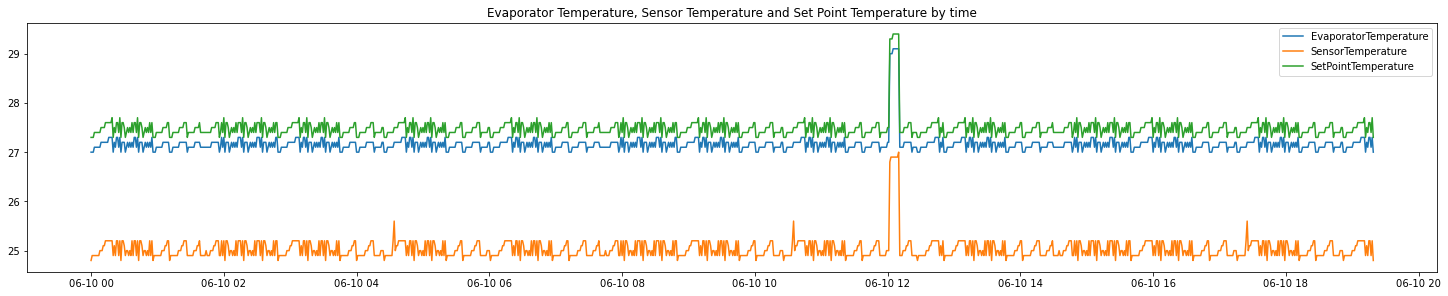

In [116]:
#inspect data
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

def plot_data(df, start_dt=None, end_dt=None):
    
    df.set_index('timestamp', inplace = True)
    start_dt = df.index[0] if start_dt is None else start_dt
    end_dt   = df.index[-1] if end_dt is None else end_dt
    
    fig = plt.figure(constrained_layout=True, figsize=(20,5))
    spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[4,1])
    ax1 = fig.add_subplot(spec[0,0])
    ax1.plot(df[['EvaporatorTemperature','SensorTemperature', 'SetPointTemperature']][start_dt:end_dt])
    ax1.legend(['EvaporatorTemperature','SensorTemperature','SetPointTemperature'])
    ax1.set_title('Evaporator Temperature, Sensor Temperature and Set Point Temperature by time')
    plt.show()

plot_data(hvac_data)

We are able to eye-ball the invoked anomaly on June 6, noon time

# Training

***

We configure a SageMaker training job to train the Random Cut Forest (RCF) algorithm on the IOT sensor data.

In [117]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=2048, #set max value
    num_trees=50, #set min value
)

# automatically upload the training data to S3 and run the training job
#train only on evaporatortemperature
rcf.fit(rcf.record_set(hvac_data["EvaporatorTemperature"].to_numpy().reshape(-1, 1)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-06-13 02:50:40 Starting - Starting the training job...
2021-06-13 02:51:04 Starting - Launching requested ML instancesProfilerReport-1623552640: InProgress
......
2021-06-13 02:52:09 Starting - Preparing the instances for training......
2021-06-13 02:53:07 Downloading - Downloading input data......
2021-06-13 02:54:06 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/13/2021 02:54:11 INFO 140152428758848] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[06/13/2021 02:54:11 INFO 1401524287588

In [118]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2021-06-13-02-50-40-590


# Inference

***

In [119]:
#create an inference endpoint
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!

In [120]:
print(f"Endpoint name: {rcf_inference.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2021-06-13-02-55-23-660


## Data Serialization/Deserialization

In [121]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above. Note that the serializer and deserializer will automatically take care of the datatype conversion from Numpy NDArrays.

For starters, let's only pass in the first six datapoints so we can see what the output looks like.

In [122]:
hvac_data_numpy = hvac_data["EvaporatorTemperature"].to_numpy().reshape(-1, 1)
print(hvac_data_numpy[:6])
results = rcf_inference.predict(
    hvac_data_numpy[:6], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

[[27. ]
 [27. ]
 [27. ]
 [27.1]
 [27.1]
 [27.1]]


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire taxi dataset.

In [123]:
results = rcf_inference.predict(hvac_data_numpy)
scores = [datum["score"] for datum in results["scores"]]

# add scores to taxi data frame and print first few values
hvac_data["score"] = pd.Series(scores, index=hvac_data.index)
hvac_data.head()

,EvaporatorTemperature,SensorTemperature,SetPointTemperature,score
timestamp,,,,
2021-06-10 00:00:00,27.0,24.8,27.3,1.475445
2021-06-10 00:01:00,27.0,24.9,27.3,1.475445
2021-06-10 00:02:00,27.0,24.9,27.3,1.475445
2021-06-10 00:03:00,27.1,24.9,27.4,1.387227
2021-06-10 00:04:00,27.1,24.9,27.4,1.387227


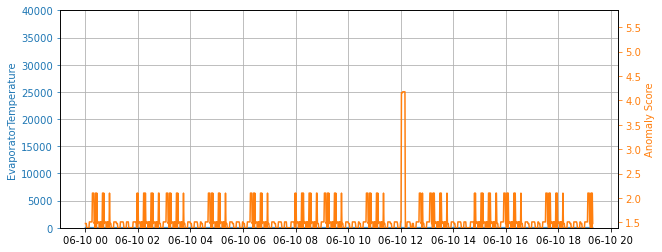

In [124]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(hvac_data)
# start, end = 5500, 6500
hvac_data_subset = hvac_data[start:end]

ax1.plot(hvac_data_subset["EvaporatorTemperature"], color="C0", alpha=0.8)
ax2.plot(hvac_data_subset["score"], color="C1")

ax1.grid(which="major", axis="both")

ax1.set_ylabel("EvaporatorTemperature", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")

ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point at around 12 pm on June 10.

In [125]:
#plot any data points with scores greater than 2.5 standard deviations from the mean score.
score_mean = hvac_data["score"].mean()
score_std = hvac_data["score"].std()

#use more conservative std. dev of 2.5 instead of 3
score_cutoff = score_mean + 2.5 * score_std

anomalies = hvac_data_subset[hvac_data_subset["score"] > score_cutoff]
anomalies

,EvaporatorTemperature,SensorTemperature,SetPointTemperature,score
timestamp,,,,
2021-06-10 12:02:00,29.0,26.8,29.3,4.155804
2021-06-10 12:03:00,29.0,26.9,29.3,4.155804
2021-06-10 12:04:00,29.0,26.9,29.3,4.155804
2021-06-10 12:05:00,29.1,26.9,29.4,4.175325
2021-06-10 12:06:00,29.1,26.9,29.4,4.175325
2021-06-10 12:07:00,29.1,26.9,29.4,4.175325
2021-06-10 12:08:00,29.1,26.9,29.4,4.175325
2021-06-10 12:09:00,29.1,26.9,29.4,4.175325
2021-06-10 12:10:00,29.1,27.0,29.4,4.175325


Our algorithm managed to capture the anomoly invoked in a test environment. Below we add these anomalies to the score plot.

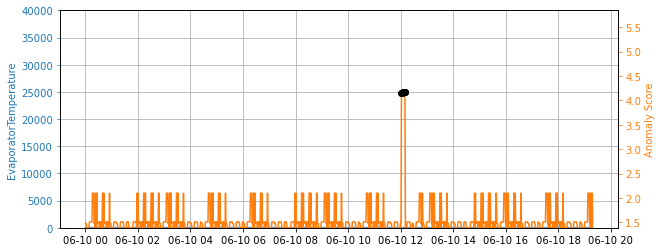

In [126]:
ax2.plot(anomalies.index, anomalies.score, "ko")
fig

With the current hyperparameter choices we see that the three-standard-deviation threshold, while able to capture the known anomalies. 

We expect a similar response in a real-world environment. However, we can expect to see more variation in the compressor temperature readings even under non-anomalous conditions. 

In this problem, we want to maximize for recall. So instead of calculating cut-off using the conventional 3 standard deviations from the mean, we'll use a more conservative anomaly cut-off of 2.5 standard deviations from the mean.

In [127]:
from decimal import *
dynamodb_table = boto3.resource('dynamodb', region_name= region).Table('anomaly_cutoff')
dynamodb_table.put_item(Item= {'data_kind': 'sensor_data', 'update_time':  strftime("%Y%m%d%H%M%S", gmtime()), 'score_cutoff': Decimal(str(score_cutoff)) })
print('myINFO : New score_cutoff value has been updated in DynamoDB table.')

myINFO : New score_cutoff value has been updated in DynamoDB table.


In [129]:
# #test data to simulate anomalous condition
# import boto3
# dynamodb = boto3.client('dynamodb')
# dynamodb.put_item(TableName='HVACData', Item={'Timestamp':{'S':'2021-06-11T06:15:19Z'},
#                                               'EvaporatorTemperature':{'N':'30.5'},
#                                               'SensorTemperature':{'N':'30.5'},
#                                               'SetPointTemperature':{'N':'30.5'}})

# dynamodb.put_item(TableName='HVACData', Item={'Timestamp':{'S':'2021-06-11T06:15:19Z'},
#                                               'EvaporatorTemperature':{'N':'30.5'},
#                                               'SensorTemperature':{'N':'30.5'},
#                                               'SetPointTemperature':{'N':'30.5'}})

# dynamodb.put_item(TableName='HVACData', Item={'Timestamp':{'S':'2021-06-11T06:16:19Z'},
#                                               'EvaporatorTemperature':{'N':'30.5'},
#                                               'SensorTemperature':{'N':'30.5'},
#                                               'SetPointTemperature':{'N':'30.5'}})

# dynamodb.put_item(TableName='HVACData', Item={'Timestamp':{'S':'2021-06-11T06:17:19Z'},
#                                               'EvaporatorTemperature':{'N':'30.5'},
#                                               'SensorTemperature':{'N':'30.5'},
#                                               'SetPointTemperature':{'N':'30.5'}})

# dynamodb.put_item(TableName='HVACData', Item={'Timestamp':{'S':'2021-06-11T06:19:19Z'},
#                                               'EvaporatorTemperature':{'N':'30.5'},
#                                               'SensorTemperature':{'N':'30.5'},
#                                               'SetPointTemperature':{'N':'30.5'}})

# dynamodb.put_item(TableName='HVACData', Item={'Timestamp':{'S':'2021-06-11T06:20:19Z'},
#                                               'EvaporatorTemperature':{'N':'30.5'},
#                                               'SensorTemperature':{'N':'30.5'},
#                                               'SetPointTemperature':{'N':'30.5'}})

# dynamodb.put_item(TableName='HVACData', Item={'Timestamp':{'S':'2021-06-11T06:21:19Z'},
#                                               'EvaporatorTemperature':{'N':'30.5'},
#                                               'SensorTemperature':{'N':'30.5'},
#                                               'SetPointTemperature':{'N':'30.5'}})

# dynamodb.put_item(TableName='HVACData', Item={'Timestamp':{'S':'2021-06-11T06:22:19Z'},
#                                               'EvaporatorTemperature':{'N':'30.5'},
#                                               'SensorTemperature':{'N':'30.5'},
#                                               'SetPointTemperature':{'N':'30.5'}})

# dynamodb.put_item(TableName='HVACData', Item={'Timestamp':{'S':'2021-06-11T06:24:19Z'},
#                                               'EvaporatorTemperature':{'N':'30.6'},
#                                               'SensorTemperature':{'N':'30.5'},
#                                               'SetPointTemperature':{'N':'30.5'}})

{'ResponseMetadata': {'RequestId': 'C8PRNHPN7IG3S0GUGE3OPB3APFVV4KQNSO5AEMVJF66Q9ASUAAJG',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'server': 'Server',
   'date': 'Sun, 13 Jun 2021 03:28:22 GMT',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'C8PRNHPN7IG3S0GUGE3OPB3APFVV4KQNSO5AEMVJF66Q9ASUAAJG',
   'x-amz-crc32': '2745614147'},
  'RetryAttempts': 0}}

## Stop and Delete the Endpoint

In [130]:
# sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
